In [1]:
!pip install scikit-image opencv-python xgboost lightgbm


In [4]:
from google.colab import files
uploaded = files.upload()


Saving plant-pathology-2020-fgvc7.zip to plant-pathology-2020-fgvc7 (1).zip


In [22]:
import zipfile
import os

zip_path = '/content/plant-pathology-2020-fgvc7 (1).zip'
extract_path = '/content/plant_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete.")


Extraction complete.


In [23]:
import os
os.listdir(extract_path)


['test.csv', 'images', 'sample_submission.csv', 'train.csv']

In [29]:

import pandas as pd
csv_path = os.path.join(extract_path, 'train.csv')
df = pd.read_csv(csv_path)

label_columns = ['healthy', 'multiple_diseases', 'rust', 'scab']


df['label'] = df[label_columns].idxmax(axis=1)

df.head()


,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


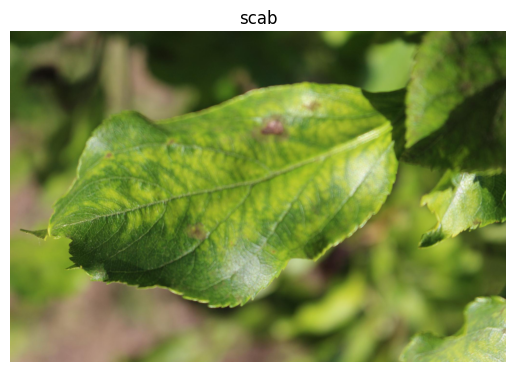

In [30]:
import matplotlib.pyplot as plt
import cv2
import os

image_folder = os.path.join(extract_path, 'images')

img_name = df['image_id'][0] + '.jpg'
img_path = os.path.join(image_folder, img_name)

img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title(df['label'][0])
plt.axis('off')
plt.show()


In [31]:
from skimage.feature import local_binary_pattern
import numpy as np

def extract_features(image):

    image = cv2.resize(image, (128, 128))


    hist = cv2.calcHist([image], [0, 1, 2], None, [8,8,8], [0,256,0,256,0,256])
    hist = cv2.normalize(hist, hist).flatten()

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    (lbp_hist, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, 27),
                                 range=(0, 26))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    return np.hstack([hist, lbp_hist])


In [32]:
X = []
y = []

for i, row in df.iterrows():
    img_file = os.path.join(image_folder, row['image_id'] + '.jpg')
    img = cv2.imread(img_file)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    feat = extract_features(img)
    X.append(feat)
    y.append(row['label'])

X = np.array(X)
y = np.array(y)


In [33]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [35]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)


SVC(probability=True)

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)


RandomForestClassifier()

In [37]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:07:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)


==== SVM ====


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                   precision    recall  f1-score   support

          healthy       0.62      0.55      0.58       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.58      0.60      0.59       125
             scab       0.56      0.67      0.61       119

         accuracy                           0.58       365
        macro avg       0.44      0.46      0.45       365
     weighted avg       0.55      0.58      0.57       365



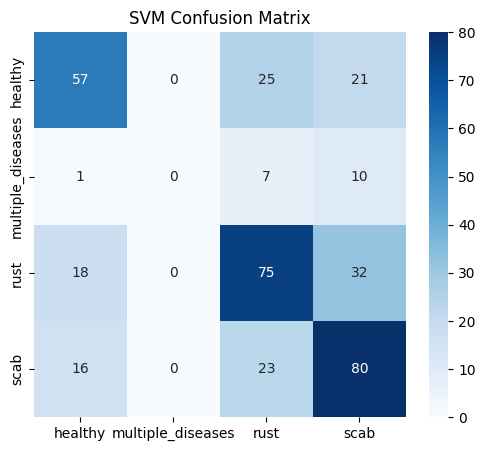


==== Random Forest ====
                   precision    recall  f1-score   support

          healthy       0.73      0.72      0.73       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.88      0.98      0.92       125
             scab       0.74      0.77      0.76       119

         accuracy                           0.79       365
        macro avg       0.59      0.62      0.60       365
     weighted avg       0.75      0.79      0.77       365



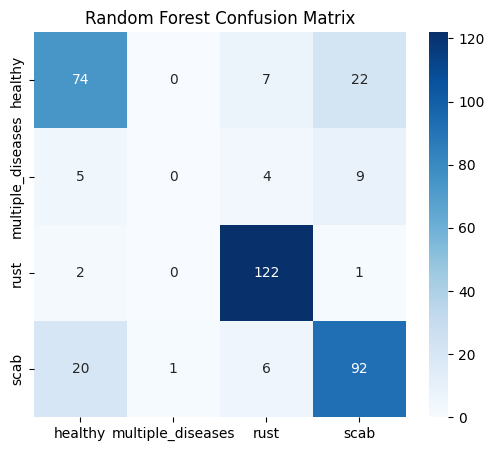


==== XGBoost ====
                   precision    recall  f1-score   support

          healthy       0.76      0.79      0.77       103
multiple_diseases       0.20      0.06      0.09        18
             rust       0.92      0.96      0.94       125
             scab       0.78      0.81      0.79       119

         accuracy                           0.82       365
        macro avg       0.67      0.65      0.65       365
     weighted avg       0.79      0.82      0.80       365



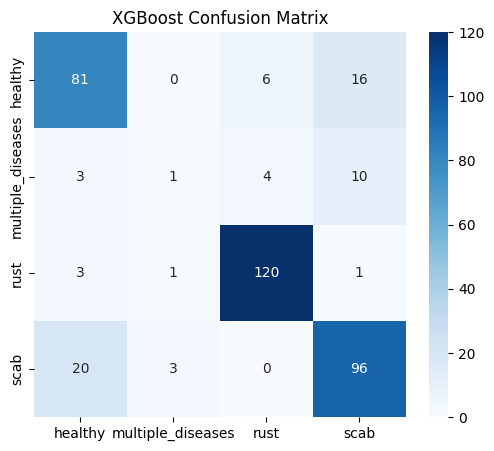

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

models = {'SVM': svm, 'Random Forest': rf, 'XGBoost': xgb}

for name, model in models.items():
    print(f"\n==== {name} ====")
    preds = model.predict(X_test)
    print(classification_report(y_test, preds, target_names=le.classes_))

    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, xticklabels=le.classes_, yticklabels=le.classes_, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()
